# Computation and saving of SPS scores

This notebook is aimed at computing, for a given experiment with n members, the Spatial Probability Score (SPS, Goessling and Jung, 2018) applied to the sea ice edge:

$SPS = \int_x \int_y [P[c>c_e](x,y)-P[c>c_e]_{ref}(x,y)]^2 dx dy$

with $P[c>c_e]$ the probability of having a concentration strictly superior to $c_e$. $c_e$ is generally 0.15 (default value here), but it could be changed if needed and/or wanted.

In this notebook, the SPS is computed in two different ways:

- taking each member of the experiment of interest one after another as reference: SPSintra (the one commented on in Fiol et al., 2026)

  In this case, $P[c>c_e]$ is computed as the frequency of the event $[c>c_e]$ taking into account n-1 members of the experiment of interest, and $P[c>c_e]_{ref}$ is a mask equal to 1 where the member of reference has a concentration superior to $c_e$ and 0 elsewhere.

- taking each member of an experiment of reference (with $n_{ref}$ members) one after another as reference: SPSinter (not in Fiol et al., 2026)

  In this case, $P[c>c_e]$ is computed as the frequency of the event $[c>c_e]$ taking into account all the members of the experiment of interest, and $P[c>c_e]_{ref}$ is a mask equal to 1 where the member of reference of the experiment of reference has a concentration superior to $c_e$ and 0 elsewhere.

We also compute in this notebook a decomposition of SPSinter:

$SPSinter = IIEEinter + residual = Ointer + Uinter + residual$

With IIEEinter the Integrated Ice-Edge Error (IIEE, Goessling et al., 2016) computed for the ensemble-median ice edge, i.e., the 50%-contour of $P[c>c_e]$. The residual is equal to 0 for determinist forecasts. Ointer and Uinter components of the decomposition are computed here using:

$Ointer = \int_x \int_y max(bin_c - bin_{c,ref},0) dx dy$  

$Uinter = \int_x \int_y max(bin_{c,ref} - bin_c,0) dx dy$

$bin_c$ is a variable equal to 1 where $P[c>c_e]$ is superior to 50% and 0 elsewhere. $bin_{c,ref}$ is computed as a mask equal to 1 where the concentration of the reference member of the experiment of reference is superior to $c_e$ and 0 elsewhere.

In this notebook, it is possible to compute SPSintra, SPSinter, Ointer and Uinter over different domains (defined below). One NetCDF file is created for each domain.

All the functions used here come from the homemade Python package: libiceedge.py. So, make sure to install Python_library library and that Python is able to locate it: put **export PYTHONPATH=<path_to_Python_library\>:${PYTHONPATH}** in your .bashrc, .profile or equivalent.

### Loading the libraries and data

In [1]:
#Importation of the different libraries

##Loading of the NetCDF files
import xarray as xr

##Computing
import numpy as np
import libiceedge

##Display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from cmocean import cm

Name: libiceedge
Package: 
This is a collection of functions to look at the sea ice edge.
Name: libdiv
Package: 
This is a collection of diverse functions.


In [2]:
#Some useful variables to load the data
diri="/lustre/fsstor/projects/rech/cli/commun/NANUK4/" #path to the directory containing all the experiments
##prefix and suffix of directories containing experiments
simu_prefix="NANUK4_ICE_ABL"
simu_suffix="-S"
##some variables about the period that interests us
time_intervalle="00010201-00011400"
period_interest="19970327_19970405"

In [3]:
#Loading the sea ice data corresponding to the experiment of interest

##Definition of some useful variables related to the experiment of interest
exp="EBLKBBM001" #experiment of interest
nb_member=20 ; list_member=np.arange(0,nb_member,1)
fq_outputs="1h" 
print(exp,fq_outputs,nb_member,list_member)

##Loading the files containing the sea ice variables of the different members
dat=[] #list that will contain the members of the experiment of interest
for k in range(1,nb_member+1):#for all the members
    path=diri+simu_prefix+"-"+exp+simu_suffix+"/"+time_intervalle+"/"+str(k).zfill(3)+"*"+fq_outputs+"*"+period_interest+"*icemod.nc4" #path of the sea ice file of the member of interest
    #print(path)
    dat.append(xr.open_mfdataset(path,decode_times=True))

EBLKBBM001 1h 20 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [4]:
#Loading the sea ice data corresponding to the experiment of reference

##Definition of some useful variables related to the experiment of reference
exp_ref="EABLBBM001" #experiment of reference
nb_member_ref=20 ; list_member_ref=np.arange(0,nb_member_ref,1)
fq_outputs="1h" 
print(exp_ref,fq_outputs,nb_member_ref,list_member_ref)

##Loading the files containing the sea ice variables of the different members
dat_ref=[] #list that will contain the members of the experiment of reference
for k in range(1,nb_member_ref+1):#for all the members
    path=diri+simu_prefix+"-"+exp_ref+simu_suffix+"/"+time_intervalle+"/"+str(k).zfill(3)+"*"+fq_outputs+"*"+period_interest+"*icemod.nc4" #path of the sea ice file of the member of interest
    #print(path)
    dat_ref.append(xr.open_mfdataset(path,decode_times=True))

EABLBBM001 1h 20 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


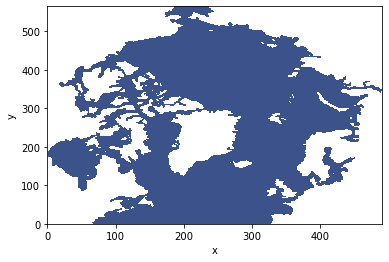

In [5]:
#Loading the file containing the horizontal meshes resolution

dat_masks=xr.open_dataset(diri+"NANUK4.L31-I/mesh_mask_NANUK4_L31_4.2_1stLev.nc")

##Visualisation of the global tmask

plt.contourf(dat_masks.tmask[0,0,:,:].where(dat_masks.tmask[0,0,:,:]>0))
plt.xlabel("x") ; plt.ylabel("y")
plt.show()

### Definition of some variables useful for the following

In [6]:
#Horizontal meshes resolution
e1=dat_masks.e1t[0,:,:] ; e2=dat_masks.e2t[0,:,:]
print("e1",e1,np.shape(dat[0]["siconc"]),np.shape(e1))
print("e2",e2,np.shape(dat[0]["siconc"]),np.shape(e1))

e1 <xarray.DataArray 'e1t' (y: 566, x: 492)>
[278472 values with dtype=float64]
Coordinates:
    time_counter  float32 0.0
Dimensions without coordinates: y, x (240, 566, 492) (566, 492)
e2 <xarray.DataArray 'e2t' (y: 566, x: 492)>
[278472 values with dtype=float64]
Coordinates:
    time_counter  float32 0.0
Dimensions without coordinates: y, x (240, 566, 492) (566, 492)


In [7]:
#Threshold value of concentration and name of the concentration variable
ce=0.15
var="siconc"
print(ce,var)

0.15 siconc


In [8]:
#Size of the time dimension, it should be the same for the experiment of interest and the experiment of reference (for all members)
size_t=dat[0].sizes["time_counter"]
print(size_t)

240


In [9]:
#Saving the time as an array

time=dat[0].time_counter.values
print(len(time)==size_t,time)

True ['1997-03-27T00:30:00.000000000' '1997-03-27T01:30:00.000000000'
 '1997-03-27T02:30:00.000000000' '1997-03-27T03:30:00.000000000'
 '1997-03-27T04:30:00.000000000' '1997-03-27T05:30:00.000000000'
 '1997-03-27T06:30:00.000000000' '1997-03-27T07:30:00.000000000'
 '1997-03-27T08:30:00.000000000' '1997-03-27T09:30:00.000000000'
 '1997-03-27T10:30:00.000000000' '1997-03-27T11:30:00.000000000'
 '1997-03-27T12:30:00.000000000' '1997-03-27T13:30:00.000000000'
 '1997-03-27T14:30:00.000000000' '1997-03-27T15:30:00.000000000'
 '1997-03-27T16:30:00.000000000' '1997-03-27T17:30:00.000000000'
 '1997-03-27T18:30:00.000000000' '1997-03-27T19:30:00.000000000'
 '1997-03-27T20:30:00.000000000' '1997-03-27T21:30:00.000000000'
 '1997-03-27T22:30:00.000000000' '1997-03-27T23:30:00.000000000'
 '1997-03-28T00:30:00.000000000' '1997-03-28T01:30:00.000000000'
 '1997-03-28T02:30:00.000000000' '1997-03-28T03:30:00.000000000'
 '1997-03-28T04:30:00.000000000' '1997-03-28T05:30:00.000000000'
 '1997-03-28T06:30:0

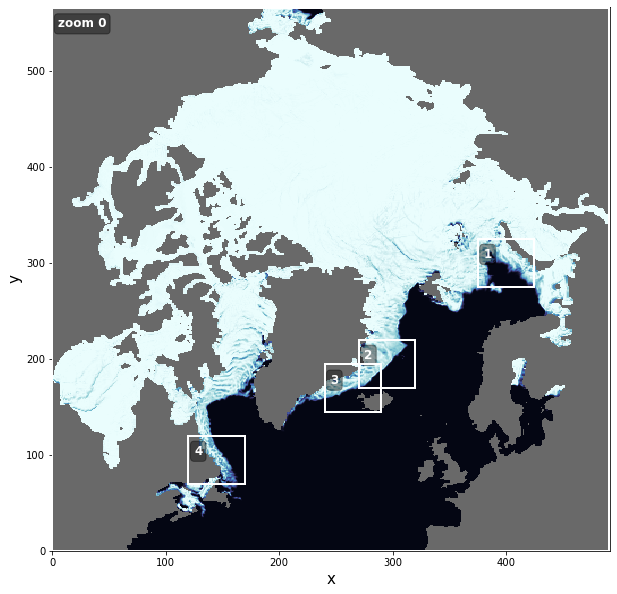

In [10]:
#Definition of some parameters for the zooms

##position of the lower corner of the zooms (a tuple per zoom)
pos_corner=[(0,0),(375,275),(270,170),(240,144),(120,70)]
##width and height of the zooms
width_height=[(491,565),(50,50),(50,50),(50,50),(50,50)]

##Quick display of the possible zooms
fig,ax=plt.subplots(1,1,figsize=(10,10))
plt.pcolormesh(dat[0].siconc[0,:,:].where(dat_masks.tmask[0,0,:,:]>0),cmap=cm.ice) #display a background ice concentration map
for izoom in range(len(pos_corner)):
    ax.add_patch(patches.Rectangle((pos_corner[izoom][0],pos_corner[izoom][1]), \
                                                 width_height[izoom][0], width_height[izoom][1],\
                                                 facecolor="None",edgecolor="white",lw=2,zorder=5)) #display of where the zoom is
    ##display a legend for each zoom 
    if izoom==0:
        ax.text(pos_corner[izoom][0]+5,pos_corner[izoom][1]+width_height[izoom][1]-20,"zoom "+str(izoom),\
            color="white",fontweight="bold",fontsize=12,\
            bbox=dict(facecolor='black', edgecolor='black',alpha=0.4, boxstyle='round'))
    else:
        ax.text(pos_corner[izoom][0]+5,pos_corner[izoom][1]+width_height[izoom][1]-20,str(izoom),\
            color="white",fontweight="bold",fontsize=12,\
            bbox=dict(facecolor='black', edgecolor='black',alpha=0.4, boxstyle='round'))
ax.set_facecolor("dimgrey")
ax.set_xlabel("x",fontsize=15) ; ax.set_ylabel("y",fontsize=15)
plt.show()

In [11]:
#Choose the zoom(s) of interest (0, 1, 2, 3 or 4)
#zooms_interest=[0,1,2,3,4]
zooms_interest=[0]
print(zooms_interest)

[0]


### Computation of the scores

In [12]:
#Computation of the SPS for the experiment of interest over the domain(s) of interest
##taking one member after another of the same ensemble as the reference
      
if 0 in zooms_interest:
    print("zoom0")
    SPSse_zoom0=libiceedge.fSPS_IIEE(dat,"same_ens",False,var,ce,e1,e2,\
                        pos_corner[0],width_height[0][0],width_height[0][1])
if 1 in zooms_interest:
    print("zoom1")
    SPSse_zoom1=libiceedge.fSPS_IIEE(dat,"same_ens",False,var,ce,e1,e2,\
                        pos_corner[1],width_height[1][0],width_height[1][1])
if 2 in zooms_interest:
    print("zoom2")
    SPSse_zoom2=libiceedge.fSPS_IIEE(dat,"same_ens",False,var,ce,e1,e2,\
                        pos_corner[2],width_height[2][0],width_height[2][1])
if 3 in zooms_interest:
    print("zoom3")
    SPSse_zoom3=libiceedge.fSPS_IIEE(dat,"same_ens",False,var,ce,e1,e2,\
                        pos_corner[3],width_height[3][0],width_height[3][1])
if 4 in zooms_interest:
    print("zoom4")
    SPSse_zoom4=libiceedge.fSPS_IIEE(dat,"same_ens",False,var,ce,e1,e2,\
                        pos_corner[4],width_height[4][0],width_height[4][1])

zoom0
computation over the specified domain
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 

In [13]:
#Computation of the SPS for the experiment of interest over the domain(s) of interest
##taking one member after another of the experiment of reference as reference

if 0 in zooms_interest:
    print("zoom0")
    SPSoe_zoom0=libiceedge.fSPS_IIEE(dat,"other_ens",dat_ref,var,ce,e1,e2,\
                        pos_corner[0],width_height[0][0],width_height[0][1])
if 1 in zooms_interest:
    print("zoom1")
    SPSoe_zoom1=libiceedge.fSPS_IIEE(dat,"other_ens",dat_ref,var,ce,e1,e2,\
                        pos_corner[1],width_height[1][0],width_height[1][1])
if 2 in zooms_interest:
    print("zoom2")
    SPSoe_zoom2=libiceedge.fSPS_IIEE(dat,"other_ens",dat_ref,var,ce,e1,e2,\
                        pos_corner[2],width_height[2][0],width_height[2][1])
if 3 in zooms_interest:
    print("zoom3")
    SPSoe_zoom3=libiceedge.fSPS_IIEE(dat,"other_ens",dat_ref,var,ce,e1,e2,\
                        pos_corner[3],width_height[3][0],width_height[3][1])
if 4 in zooms_interest:
    print("zoom4")
    SPSoe_zoom4=libiceedge.fSPS_IIEE(dat,"other_ens",dat_ref,var,ce,e1,e2,\
                        pos_corner[4],width_height[4][0],width_height[4][1])

zoom0
computation over the specified domain
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 492) (566, 492)
(240, 566, 492) (240, 566, 492) (566, 

In [14]:
#Computation of the Ooe and Uoe components of SPSoe

if 0 in zooms_interest:
    print("zoom0")
    OUoe_zoom0=libiceedge.fOU_IIEE(dat,"other_ens",dat_ref,var,ce,e1,e2,\
                        pos_corner[0],width_height[0][0],width_height[0][1])
if 1 in zooms_interest:
    print("zoom1")
    OUoe_zoom1=libiceedge.fOU_IIEE(dat,"other_ens",dat_ref,var,ce,e1,e2,\
                        pos_corner[1],width_height[1][0],width_height[1][1])
if 2 in zooms_interest:
    print("zoom2")
    OUoe_zoom2=libiceedge.fOU_IIEE(dat,"other_ens",dat_ref,var,ce,e1,e2,\
                        pos_corner[2],width_height[2][0],width_height[2][1])
if 3 in zooms_interest:
    print("zoom3")
    OUoe_zoom3=libiceedge.fOU_IIEE(dat,"other_ens",dat_ref,var,ce,e1,e2,\
                        pos_corner[3],width_height[3][0],width_height[3][1])
if 4 in zooms_interest:
    print("zoom4")
    OUoe_zoom4=libiceedge.fOU_IIEE(dat,"other_ens",dat_ref,var,ce,e1,e2,\
                        pos_corner[4],width_height[4][0],width_height[4][1])

zoom0
computation over the specified domain
member 0
(240, 566, 492) (240, 566, 492) (240, 566, 492) (240, 566, 492) (240, 566, 492)
member 1
(240, 566, 492) (240, 566, 492) (240, 566, 492) (240, 566, 492) (240, 566, 492)
member 2
(240, 566, 492) (240, 566, 492) (240, 566, 492) (240, 566, 492) (240, 566, 492)
member 3
(240, 566, 492) (240, 566, 492) (240, 566, 492) (240, 566, 492) (240, 566, 492)
member 4
(240, 566, 492) (240, 566, 492) (240, 566, 492) (240, 566, 492) (240, 566, 492)
member 5
(240, 566, 492) (240, 566, 492) (240, 566, 492) (240, 566, 492) (240, 566, 492)
member 6
(240, 566, 492) (240, 566, 492) (240, 566, 492) (240, 566, 492) (240, 566, 492)
member 7
(240, 566, 492) (240, 566, 492) (240, 566, 492) (240, 566, 492) (240, 566, 492)
member 8
(240, 566, 492) (240, 566, 492) (240, 566, 492) (240, 566, 492) (240, 566, 492)
member 9
(240, 566, 492) (240, 566, 492) (240, 566, 492) (240, 566, 492) (240, 566, 492)
member 10
(240, 566, 492) (240, 566, 492) (240, 566, 492) (240, 56

### Saving the results into NetCDF files

In [15]:
#Localisation of the outputs
#path_results="/lustre/fsstor/projects/rech/cli/commun/Arctic-BLISS_LF/"+exp+"/"+period_interest+"/SPS/"
path_results=""

In [16]:
#Saving the scores for zoom 0 if asked
if 0 in zooms_interest:
    print("zoom0")
    ds_zoom0 = xr.Dataset(
        {
        "SPSintra":    (["member_ref_intra","time"], np.array(SPSse_zoom0[0])),
        "SPSinter":    (["member_ref_inter","time"], np.array(SPSoe_zoom0[0])),
        "Ointer":    (["member_ref_inter","time"], np.array(OUoe_zoom0[0])[:,0,:]),
        "Uinter":    (["member_ref_inter","time"], np.array(OUoe_zoom0[0])[:,1,:]),
        },
        coords={
        "time": time,
        "member_ref_intra": list_member,
        "member_ref_inter": list_member_ref
        },
    )

    #attributes/encoding for time coordinate
    ds_zoom0.time.encoding['units'] = "seconds since 1970-01-01 00:00:00"
    ds_zoom0.time.encoding['_FillValue'] = None
    ds_zoom0.time.attrs['standard_name'] = 'time'

    #attributes for each variable
    ##SPSintra
    ds_zoom0["SPSintra"].attrs['_FillValue'] = -1.e20
    ds_zoom0["SPSintra"].attrs['units'] = "m2"
    ds_zoom0["SPSintra"].attrs['long_name'] = "SPS score computed taking one member after another of "+exp+" as reference for zoom0"
    ##SPSinter
    ds_zoom0["SPSinter"].attrs['_FillValue'] = -1.e20
    ds_zoom0["SPSinter"].attrs['units'] = "m2"
    ds_zoom0["SPSinter"].attrs['long_name'] = "SPS score computed taking one member after another of "+exp_ref+" as reference for zoom0"
    ##Ointer
    ds_zoom0["Ointer"].attrs['_FillValue'] = -1.e20
    ds_zoom0["Ointer"].attrs['units'] = "m2"
    ds_zoom0["Ointer"].attrs['long_name'] = "Ointer component of SPSinter for zoom0"
    ##Uinter
    ds_zoom0["Uinter"].attrs['_FillValue'] = -1.e20
    ds_zoom0["Uinter"].attrs['units'] = "m2"
    ds_zoom0["Uinter"].attrs['long_name'] = "Uinter component of SPSinter for zoom0"

    #global attribute:
    ds_zoom0.attrs['history'] = 'Created using script 05-03-2025_SPS_computation.ipynb that used the homemade python library libiceedge. ce is taken equal to '+str(ce)+"."

    #write the file with UNLIMITED time:
    ds_zoom0.to_netcdf(path_results+"SPS_"+exp+"compto"+exp_ref+"_zoom0_"+period_interest+".nc",unlimited_dims="time")

zoom0


In [17]:
#Saving the scores for zoom 1 if asked
if 1 in zooms_interest:
    print("zoom1")
    ds_zoom1 = xr.Dataset(
        {
        "SPSintra":    (["member_ref_intra","time"], np.array(SPSse_zoom1[0])),
        "SPSinter":    (["member_ref_inter","time"], np.array(SPSoe_zoom1[0])),
        "Ointer":    (["member_ref_inter","time"], np.array(OUoe_zoom1[0])[:,0,:]),
        "Uinter":    (["member_ref_inter","time"], np.array(OUoe_zoom1[0])[:,1,:]),
        },
        coords={
        "time": time,
        "member_ref_intra": list_member,
        "member_ref_inter": list_member_ref
        },
    )

    #attributes/encoding for time coordinate
    ds_zoom1.time.encoding['units'] = "seconds since 1970-01-01 00:00:00"
    ds_zoom1.time.encoding['_FillValue'] = None
    ds_zoom1.time.attrs['standard_name'] = 'time'

    #attributes for each variable
    ##SPSintra
    ds_zoom1["SPSintra"].attrs['_FillValue'] = -1.e20
    ds_zoom1["SPSintra"].attrs['units'] = "m2"
    ds_zoom1["SPSintra"].attrs['long_name'] = "SPS score computed taking one member after another of "+exp+" as reference for zoom1"
    ##SPSinter
    ds_zoom1["SPSinter"].attrs['_FillValue'] = -1.e20
    ds_zoom1["SPSinter"].attrs['units'] = "m2"
    ds_zoom1["SPSinter"].attrs['long_name'] = "SPS score computed taking one member after another of "+exp_ref+" as reference for zoom1"
    ##Ointer
    ds_zoom1["Ointer"].attrs['_FillValue'] = -1.e20
    ds_zoom1["Ointer"].attrs['units'] = "m2"
    ds_zoom1["Ointer"].attrs['long_name'] = "Ointer component of SPSinter for zoom1"
    ##Uinter
    ds_zoom1["Uinter"].attrs['_FillValue'] = -1.e20
    ds_zoom1["Uinter"].attrs['units'] = "m2"
    ds_zoom1["Uinter"].attrs['long_name'] = "Uinter component of SPSinter for zoom1"

    #global attribute:
    ds_zoom1.attrs['history'] = 'Created using script 05-03-2025_SPS_computation.ipynb that used the homemade python library libiceedge. ce is taken equal to '+str(ce)+"."

    #write the file with UNLIMITED time:
    ds_zoom1.to_netcdf(path_results+"SPS_"+exp+"compto"+exp_ref+"_zoom1_"+period_interest+".nc",unlimited_dims="time")

In [18]:
#Saving the scores for zoom 2 if asked
if 2 in zooms_interest:
    print("zoom2")
    ds_zoom2 = xr.Dataset(
        {
        "SPSintra":    (["member_ref_intra","time"], np.array(SPSse_zoom2[0])),
        "SPSinter":    (["member_ref_inter","time"], np.array(SPSoe_zoom2[0])),
        "Ointer":    (["member_ref_inter","time"], np.array(OUoe_zoom2[0])[:,0,:]),
        "Uinter":    (["member_ref_inter","time"], np.array(OUoe_zoom2[0])[:,1,:]),
        },
        coords={
        "time": time,
        "member_ref_intra": list_member,
        "member_ref_inter": list_member_ref
        },
    )

    #attributes/encoding for time coordinate
    ds_zoom2.time.encoding['units'] = "seconds since 1970-01-01 00:00:00"
    ds_zoom2.time.encoding['_FillValue'] = None
    ds_zoom2.time.attrs['standard_name'] = 'time'

    #attributes for each variable
    ##SPSintra
    ds_zoom2["SPSintra"].attrs['_FillValue'] = -1.e20
    ds_zoom2["SPSintra"].attrs['units'] = "m2"
    ds_zoom2["SPSintra"].attrs['long_name'] = "SPS score computed taking one member after another of "+exp+" as reference for zoom2"
    ##SPSinter
    ds_zoom2["SPSinter"].attrs['_FillValue'] = -1.e20
    ds_zoom2["SPSinter"].attrs['units'] = "m2"
    ds_zoom2["SPSinter"].attrs['long_name'] = "SPS score computed taking one member after another of "+exp_ref+" as reference for zoom2"
    ##Ointer
    ds_zoom2["Ointer"].attrs['_FillValue'] = -1.e20
    ds_zoom2["Ointer"].attrs['units'] = "m2"
    ds_zoom2["Ointer"].attrs['long_name'] = "Ointer component of SPSinter for zoom2"
    ##Uinter
    ds_zoom2["Uinter"].attrs['_FillValue'] = -1.e20
    ds_zoom2["Uinter"].attrs['units'] = "m2"
    ds_zoom2["Uinter"].attrs['long_name'] = "Uinter component of SPSinter for zoom2"

    #global attribute:
    ds_zoom2.attrs['history'] = 'Created using script 05-03-2025_SPS_computation.ipynb that used the homemade python library libiceedge. ce is taken equal to '+str(ce)+"."

    #write the file with UNLIMITED time:
    ds_zoom2.to_netcdf(path_results+"SPS_"+exp+"compto"+exp_ref+"_zoom2_"+period_interest+".nc",unlimited_dims="time")

In [19]:
#Saving the scores for zoom 3 if asked
if 3 in zooms_interest:
    print("zoom3")
    ds_zoom3 = xr.Dataset(
        {
        "SPSintra":    (["member_ref_intra","time"], np.array(SPSse_zoom3[0])),
        "SPSinter":    (["member_ref_inter","time"], np.array(SPSoe_zoom3[0])),
        "Ointer":    (["member_ref_inter","time"], np.array(OUoe_zoom3[0])[:,0,:]),
        "Uinter":    (["member_ref_inter","time"], np.array(OUoe_zoom3[0])[:,1,:]),
        },
        coords={
        "time": time,
        "member_ref_intra": list_member,
        "member_ref_inter": list_member_ref
        },
    )

    #attributes/encoding for time coordinate
    ds_zoom3.time.encoding['units'] = "seconds since 1970-01-01 00:00:00"
    ds_zoom3.time.encoding['_FillValue'] = None
    ds_zoom3.time.attrs['standard_name'] = 'time'

    #attributes for each variable
    ##SPSintra
    ds_zoom3["SPSintra"].attrs['_FillValue'] = -1.e20
    ds_zoom3["SPSintra"].attrs['units'] = "m2"
    ds_zoom3["SPSintra"].attrs['long_name'] = "SPS score computed taking one member after another of "+exp+" as reference for zoom3"
    ##SPSinter
    ds_zoom3["SPSinter"].attrs['_FillValue'] = -1.e20
    ds_zoom3["SPSinter"].attrs['units'] = "m2"
    ds_zoom3["SPSinter"].attrs['long_name'] = "SPS score computed taking one member after another of "+exp_ref+" as reference for zoom3"
    ##Ointer
    ds_zoom3["Ointer"].attrs['_FillValue'] = -1.e20
    ds_zoom3["Ointer"].attrs['units'] = "m2"
    ds_zoom3["Ointer"].attrs['long_name'] = "Ointer component of SPSinter for zoom3"
    ##Uinter
    ds_zoom3["Uinter"].attrs['_FillValue'] = -1.e20
    ds_zoom3["Uinter"].attrs['units'] = "m2"
    ds_zoom3["Uinter"].attrs['long_name'] = "Uinter component of SPSinter for zoom3"

    #global attribute:
    ds_zoom3.attrs['history'] = 'Created using script 05-03-2025_SPS_computation.ipynb that used the homemade python library libiceedge. ce is taken equal to '+str(ce)+"."

    #write the file with UNLIMITED time:
    ds_zoom3.to_netcdf(path_results+"SPS_"+exp+"compto"+exp_ref+"_zoom3_"+period_interest+".nc",unlimited_dims="time")

In [20]:
#Saving the scores for zoom 4 if asked
if 4 in zooms_interest:
    print("zoom4")
    ds_zoom4 = xr.Dataset(
        {
        "SPSintra":    (["member_ref_intra","time"], np.array(SPSse_zoom4[0])),
        "SPSinter":    (["member_ref_inter","time"], np.array(SPSoe_zoom4[0])),
        "Ointer":    (["member_ref_inter","time"], np.array(OUoe_zoom4[0])[:,0,:]),
        "Uinter":    (["member_ref_inter","time"], np.array(OUoe_zoom4[0])[:,1,:]),
        },
        coords={
        "time": time,
        "member_ref_intra": list_member,
        "member_ref_inter": list_member_ref
        },
    )

    #attributes/encoding for time coordinate
    ds_zoom4.time.encoding['units'] = "seconds since 1970-01-01 00:00:00"
    ds_zoom4.time.encoding['_FillValue'] = None
    ds_zoom4.time.attrs['standard_name'] = 'time'

    #attributes for each variable
    ##SPSintra
    ds_zoom4["SPSintra"].attrs['_FillValue'] = -1.e20
    ds_zoom4["SPSintra"].attrs['units'] = "m2"
    ds_zoom4["SPSintra"].attrs['long_name'] = "SPS score computed taking one member after another of "+exp+" as reference for zoom4"
    ##SPSinter
    ds_zoom4["SPSinter"].attrs['_FillValue'] = -1.e20
    ds_zoom4["SPSinter"].attrs['units'] = "m2"
    ds_zoom4["SPSinter"].attrs['long_name'] = "SPS score computed taking one member after another of "+exp_ref+" as reference for zoom4"
    ##Ointer
    ds_zoom4["Ointer"].attrs['_FillValue'] = -1.e20
    ds_zoom4["Ointer"].attrs['units'] = "m2"
    ds_zoom4["Ointer"].attrs['long_name'] = "Ointer component of SPSinter for zoom4"
    ##Uinter
    ds_zoom4["Uinter"].attrs['_FillValue'] = -1.e20
    ds_zoom4["Uinter"].attrs['units'] = "m2"
    ds_zoom4["Uinter"].attrs['long_name'] = "Uinter component of SPSinter for zoom4"

    #global attribute:
    ds_zoom4.attrs['history'] = 'Created using script 05-03-2025_SPS_computation.ipynb that used the homemade python library libiceedge. ce is taken equal to '+str(ce)+"."

    #write the file with UNLIMITED time:
    ds_zoom4.to_netcdf(path_results+"SPS_"+exp+"compto"+exp_ref+"_zoom4_"+period_interest+".nc",unlimited_dims="time")